In [1]:
import gpr

import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
import astropy.units as u
import astropy.constants as c
import astropy.io.fits as pf
import matplotlib.pyplot as plt

W0711 18:01:04.500033 139902768076608 logger.py:200] AstropyDeprecationWarning: astropy.extern.six will be removed in 4.0, use the six module directly if it is still needed
W0711 18:01:04.993305 139902768076608 deprecation_wrapper.py:119] From /home/fortino/anaconda3/lib/python3.7/site-packages/gpflow/session_manager.py:31: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0711 18:01:04.996284 139902768076608 deprecation_wrapper.py:119] From /home/fortino/anaconda3/lib/python3.7/site-packages/gpflow/misc.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0711 18:01:05.095681 139902768076608 deprecation_wrapper.py:119] From /home/fortino/anaconda3/lib/python3.7/site-packages/gpflow/saver/coders.py:80: The name tf.data.Iterator is deprecated. Please use tf.compat.v1.data.Iterator instead.



In [2]:
class EBF(gpflow.kernels.Kernel):
    def __init__(self, input_dim, var_s=1., sigma_x=1., sigma_y=1., phi=0., active_dims=None):
        super().__init__(input_dim=input_dim, active_dims=active_dims)
        self.var_s = gpflow.Param(var_s, transform=gpflow.transforms.positive)
        self.sigma_x = gpflow.Param(sigma_x, transform=gpflow.transforms.positive)
        self.sigma_y = gpflow.Param(sigma_x, transform=gpflow.transforms.positive)
        self.phi = gpflow.Param(phi)
    
    @gpflow.params_as_tensors
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
            
        self.u1, self.u2 = X[:, 0], X2[:, 0]
        self.v1, self.v2 = X[:, 1], X2[:, 1]
        
        self.uu1, self.uu2 = tf.meshgrid(self.u1, self.u2)
        self.vv1, self.vv2 = tf.meshgrid(self.v1, self.v2)
        
        self.a = tf.cos(self.phi)**2. / (2. * self.sigma_x**2.) + tf.sin(self.phi)**2. / (2. * self.sigma_y**2.)
        self.b = - tf.sin(2. * self.phi) / (4. * self.sigma_x**2.) + tf.sin(2. * self.phi) / (4. * self.sigma_y**2.)
        self.c = tf.sin(self.phi)**2. / (2. * self.sigma_x**2.) + tf.cos(self.phi)**2. / (2. * self.sigma_y**2.)

        self.uu = self.a * (self.uu1 - self.uu2)**2
        self.vv = self.c * (self.vv1 - self.vv2)**2
        self.uv = 2. * self.b * (self.uu1 - self.uu2)*(self.vv1 - self.vv2)
        
        return self.var_s * tf.reshape(tf.exp(-(self.uu + self.vv + self.uv)), (tf.shape(X)[0], tf.shape(X2)[0]))
    
    @gpflow.params_as_tensors
    def Kdiag(self, X):
        return self.var_s * tf.cast(tf.ones(tf.shape(X)[0]), tf.float64)

In [3]:
class ShotNoise(gpflow.kernels.Static):
    def __init__(self, input_dim, shot_noise_train, shot_noise_test, active_dims=None, name=None):
        super().__init__(input_dim=input_dim, active_dims=active_dims, name=name)
        self.shot_noise_train = shot_noise_train
        self.shot_noise_test = shot_noise_test
    
    @gpflow.params_as_tensors
    def K(self, X, X2=None):
        if X2 is not None:
            X2 = X
            return tf.linalg.diag(self.shot_noise_test)
        return tf.linalg.diag(self.shot_noise_train)
    
    @gpflow.params_as_tensors
    def Kdiag(self, X):
        return self.shot_noise_train

In [4]:
"""Generate fake data from a known covariance function."""
num = 1000
GP = gpr.GPR(
    '/data4/paper/fox/DES/austinFull.fits',
    500,
    sample=None,
    verbose=False,
    eps=0,
    test_size=0.2,
    random_state=0
)

X  = np.random.uniform(low=-1, high=1, size=(num, 2))
data = GP.gen_coordinate_arrays(X, X)
theta = np.array([
    200,
    0.009,
    0.7,
    1
])
C = GP.EBF(data, theta)
Y = np.random.multivariate_normal(np.zeros(X.shape[0]), C, size=2).T
E = np.random.uniform(low=2, high=3, size=num)

GP.X = X
GP.Y = Y
GP.E = E

GP.split_data()
GP.gen_White_Covariance()

In [5]:
# sample = np.array([-0.3, 0, 0, 0.3])
# GP = gpr.GPR(
#     '/data4/paper/fox/DES/austinFull.fits',
#     500,
#     sample=sample,
#     verbose=False,
#     eps=0,
#     test_size=0.2,
#     random_state=0)

In [6]:
kernel = EBF(2)

W0711 18:01:12.190451 139902768076608 deprecation_wrapper.py:119] From /home/fortino/anaconda3/lib/python3.7/site-packages/gpflow/core/node.py:109: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 18:01:12.247446 139902768076608 deprecation_wrapper.py:119] From /home/fortino/anaconda3/lib/python3.7/site-packages/gpflow/params/parameter.py:388: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 18:01:12.251758 139902768076608 deprecation_wrapper.py:119] From /home/fortino/anaconda3/lib/python3.7/site-packages/gpflow/params/parameter.py:394: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



In [7]:
# kernel = ShotNoise(2, GP.Etrain, GP.Etest)

In [8]:
model = gpflow.models.GPR(
    X=GP.Xtrain,
    Y=GP.Ytrain,
    kern=kernel,
    mean_function=None)

model.kern.var_s = 200
model.kern.sigma_x = 0.009
model.kern.sigma_y = 0.7
model.kern.phi = 1
model.likelihood.variance = 200

model

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/phi,Parameter,None,(none),True,(),True,1.0
GPR/kern/sigma_x,Parameter,None,+ve,True,(),True,0.009
GPR/kern/sigma_y,Parameter,None,+ve,True,(),True,0.7
GPR/kern/var_s,Parameter,None,+ve,True,(),True,200.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,200.0


In [9]:
# optimizer = gpflow.train.ScipyOptimizer()
# optimizer.minimize(model)
# model

In [10]:
mean, var = model.predict_f(GP.Xtest)

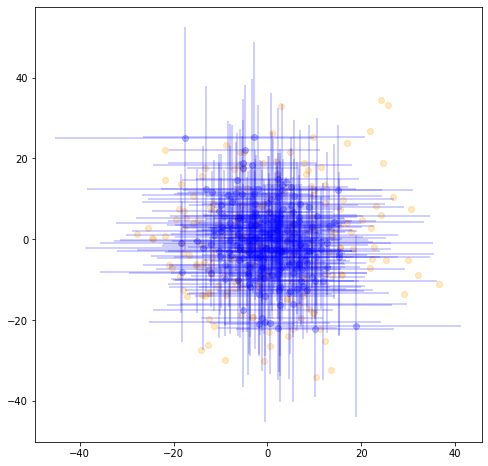

In [11]:
plt.figure(figsize=(8, 8))
# plt.ylim((-20, 20))
# plt.xlim((-20, 20))
plt.errorbar(*mean.T, *np.sqrt(np.abs(var)).T, fmt='o', color='blue', alpha=0.25)
plt.scatter(*GP.Ytest.T, color='orange', alpha=0.25)
plt.show()

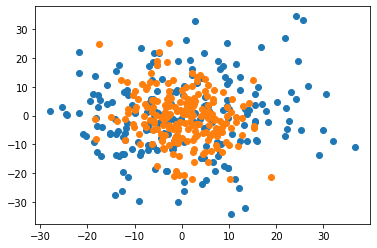

In [12]:
plt.scatter(*GP.Ytest.T)
plt.scatter(*mean.T)